## Applied - Question 9

This question will analyze the Boston dataset using non-linear methods. Specifically,
we will focus on the 2 variables
1. dis (the weighted mean of distances to five Boston employment centers)
2. nox (nitrogen oxides concentration in parts per 10 million)

We will treat dis as predictor and nox as the response

#### Import block

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as skl_lm
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
plt.style.use('seaborn-white')

Importing the data

Text(0, 0.5, 'nox')

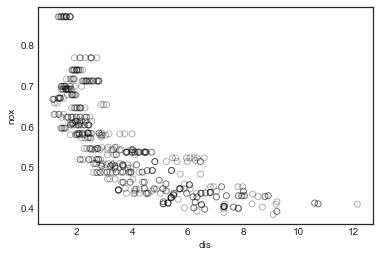

In [2]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}Boston.csv')

# Set X and y
X = df.dis
y = df.nox

# First plot
plt.scatter(X, y, facecolor='None', edgecolors='k', alpha=0.3)
plt.xlabel('dis')
plt.ylabel('nox')

#### (a) Cubic polynomial

Nicely enough, all of cubic features are statistically significant. Moreover, the regression
fits the data quite nicely except near the edge where there is a large deviation.

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9341      0.021     45.110      0.000       0.893       0.975
x1            -0.1821      0.015    -12.389      0.000      -0.211      -0.153
x2             0.0219      0.003      7.476      0.000       0.016       0.028
x3            -0.0009      0.000     -5.124      0.000      -0.001      -0.001


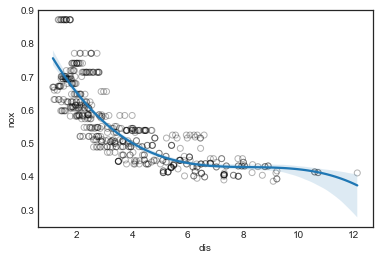

In [3]:
# Cubic poly
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X.values.reshape(-1,1))

# Regression results
regr = sm.OLS(y, X_poly).fit()
print(regr.summary().tables[1])

# Plot it out
plt.scatter(X, y, facecolor='None', edgecolors='k', alpha=0.3)
sns.regplot(X, y, order=3, truncate=True, scatter=False)

#### (b) & (c) CV the order of polynomial

Same thing we did in lab 6, 7, 8.

Wow! The jump between the degree is drastic. Nevertheless, we can see that at 4th
degree, we achieve the smallest MSE. 

Text(0, 0.5, 'MSE')

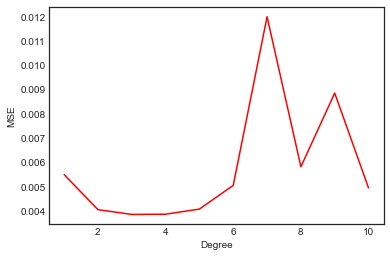

In [4]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
regr = skl_lm.LinearRegression()
MSE = []

# Loop and record MSE
for i in range(1,11):
    # Transform
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(X.values.reshape(-1,1))
    
    # Fit and MSE
    score = cross_val_score(regr, X_poly, y.ravel(), cv=kf,
                    scoring='neg_mean_squared_error').mean()
    MSE.append(-score)
    
# Plot 
plt.plot(range(1,11), MSE, color='r')
plt.xlabel('Degree')
plt.ylabel('MSE')

#### (d) Splines with df=4

Time to review the splines. We can choose the knots based on the plot. First, lets we 
use df=4 WITHOUT choosing the knots. (Result is linear since cubic will require at least 
df=7 for 3 knots.

We can choose knots base on the plot. There are big jumps in value of nox at 4, 8, and 10 .
Now, if we specify 3 knots AND use cubic splines, we will get df=7.

Intercept                                      0.381228
bs(df.dis, df=4, include_intercept=True)[0]    0.373925
bs(df.dis, df=4, include_intercept=True)[1]   -0.124347
bs(df.dis, df=4, include_intercept=True)[2]    0.140405
bs(df.dis, df=4, include_intercept=True)[3]   -0.008755
dtype: float64


Text(0, 0.5, 'NOX')

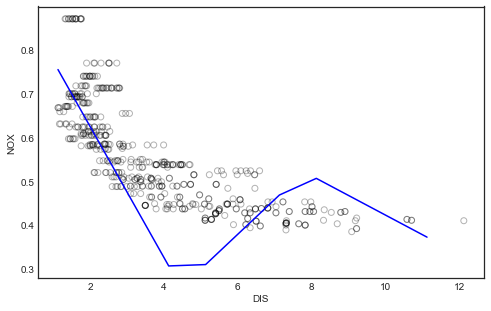

In [13]:
from patsy.highlevel import dmatrix

# Define dis grid to get the predicted values
dis_grid = np.arange(df.dis.min(), df.dis.max()).reshape(-1,1)

# Splines with specified degree of freedom
X_transformed = dmatrix("bs(df.dis, df=4, include_intercept=True)",
                        {'df.dis':df.dis}, return_type='dataframe')
X_test_transformed = dmatrix("bs(dis_grid, df=4, degree=1, include_intercept=True)",
                        {'dis_grid':dis_grid}, return_type='dataframe')

# fit regression onto splines
regr = sm.GLM(df.nox, X_transformed).fit()
y_pred_3knots = regr.predict(X_test_transformed)

# return the coefficients
print(regr.params)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(df.dis, df.nox, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(dis_grid, y_pred_3knots, color='b', label='Specifying three knots')

plt.xlabel('DIS')
plt.ylabel('NOX')

Intercept                                                            0.435679
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[0]    0.306228
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[1]    0.209929
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[2]   -0.035791
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[3]    0.037808
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[4]   -0.083760
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[5]    0.027172
bs(df.dis, knots=(4, 8, 10), degree=3, include_intercept=True)[6]   -0.025907
dtype: float64


Text(0, 0.5, 'NOX')

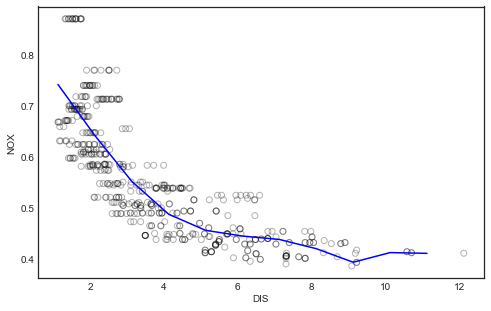

In [14]:
# Splines with specified degree of freedom
X_transformed = dmatrix("bs(df.dis, knots=(4,8,10), degree=3, include_intercept=True)",
                        {'df.dis':df.dis}, return_type='dataframe')
X_test_transformed = dmatrix("bs(dis_grid, knots=(4,8,10), degree=3, include_intercept=True)",
                        {'dis_grid':dis_grid}, return_type='dataframe')

# fit regression onto splines
regr = sm.GLM(df.nox, X_transformed).fit()
y_pred_3knots = regr.predict(X_test_transformed)

# return the coefficients
print(regr.params)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(df.dis, df.nox, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(dis_grid, y_pred_3knots, color='b', label='Specifying three knots')

plt.xlabel('DIS')
plt.ylabel('NOX')

#### (e) & (f)

I will specifically use cubic splines because it is the most practical and perform the best.

The plot shows the best results at df=6 and df=13 which indicates 2 and 9 knots respectively
I would choose 2 knots since this means less likely to over-fit the data.

Text(0, 0.5, 'MSE')

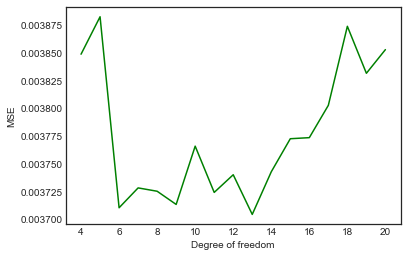

In [21]:
# Set paramaters
MSE = []
regr = skl_lm.LinearRegression()

for i in range(4, 21):
    X_transformed = dmatrix(f"bs(df.dis, df={i}, degree=3, include_intercept=True)",
                        {'df.dis':df.dis}, return_type='dataframe')
    
    # Fit and CV to get MSE
    score = cross_val_score(regr, X_transformed, y, cv=kf,
                            scoring='neg_mean_squared_error').mean()
    MSE.append(-score)

# Plot 
plt.plot(range(4,21), MSE, color='g')
plt.xlabel('Degree of freedom')
plt.ylabel('MSE')
    